In [1]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

env: THEANO_FLAGS=device=cpu,floatX=float32


# Data

In [2]:
def build_toy_dataset(N, K):
    pi = np.array([0.2, 0.5, 0.3])
    mus = [[1, 1], [-1, -1], [2,-2]]
    stds = [[0.1, 0.1], [0.1, 0.2], [0.2, 0.3]]
    x = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros((N,), dtype=np.int)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
        y[n] = k

    return x,y

N = 10000  # number of data points
D = 2  # dimensionality of data

X, y = build_toy_dataset(N, 3)


In [3]:
X.shape

(10000, 2)

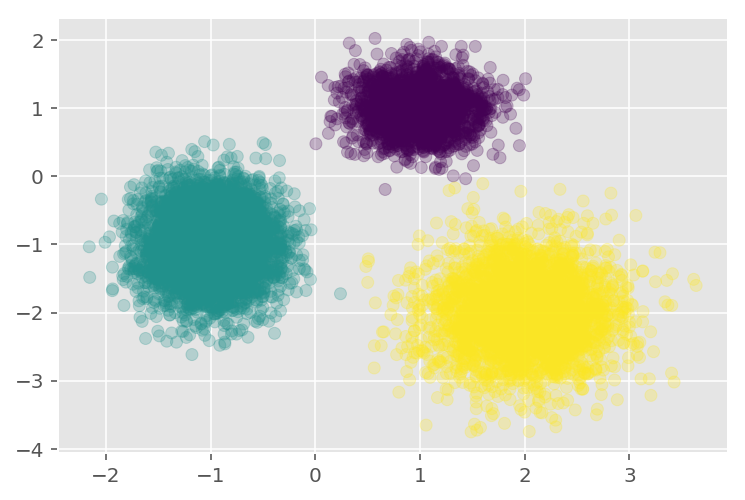

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, alpha=.25);

# Model

$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \tau_k)$

$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$

$p(\mu_k) = \text{Normal}(\mu_k | 0,I)$

$p(\tau_k ) = \text{Gamma} (\tau_k | a, b) $

In [5]:
# set up model
K = 3

X_shared = theano.shared(X)
minibatch_size = 100
X_minibatch = pm.Minibatch(X, minibatch_size)

with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    tau = []
    precision = []
    for i in range(K):
        mu.append(pm.Normal('mu%i'%i, 0, 10, shape=2))
        tau.append(pm.Gamma('tau%i'%i,1, 1, shape=2))
        
        precision.append(tt.nlinalg.alloc_diag(tau[i]))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], tau=precision[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)



In [7]:
with model:
    advi = pm.ADVI()
    advi.fit(5000, more_replacements={X_shared: X_minibatch}, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 261.78: 100%|██████████| 5000/5000 [00:19<00:00, 255.09it/s]
Finished [100%]: Average Loss = 261.71


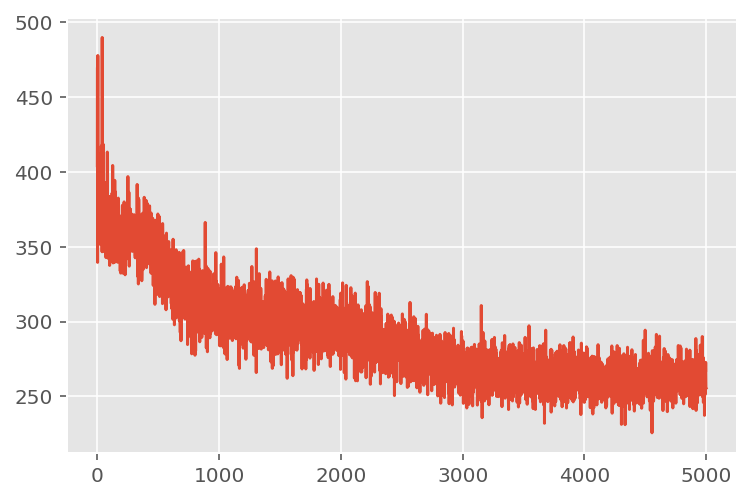

In [8]:
plt.plot(advi.hist)

# Prediction

First, we use the posterior to do clustering.

In [29]:
def predict_cluster(approx, nsample, X, model, K, cov="full"):
    xobs = model.x_obs
    complogp = xobs.distribution._comp_logp(theano.shared(X))
    f_complogp = model.model.fastfn(complogp)
    trace = approx.sample(nsample)

    point = model.test_point

    for i in np.arange(K):
        point['mu%i' % i] = np.mean(trace['mu%i' % i], axis=0)  # take average over samples

        if cov == "full":
            label = 'chol_cov_%i_cholesky-cov-packed__' % i

        elif cov == "diagonal":
            label = 'tau%i_log__' % i

        point[label] = np.mean(trace[label], axis=0)

    y = np.argmax(f_complogp(point), axis=1)
    return y, point

In [31]:
y_assign, point = predict_cluster(advi.approx, 1000, X, model, K, cov="diagonal")

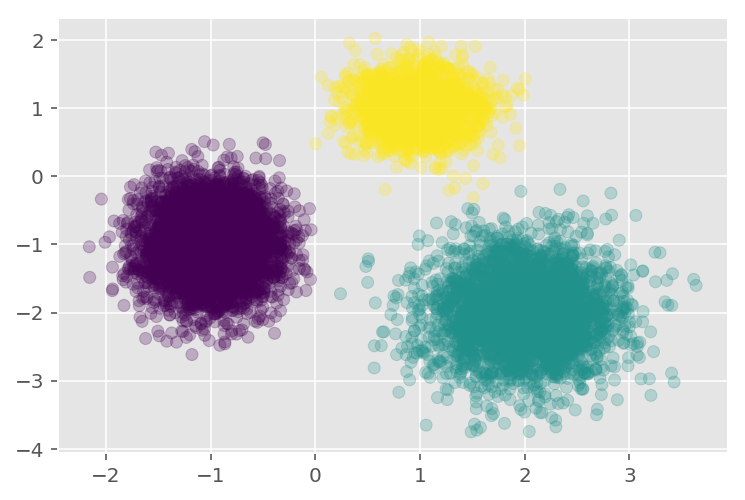

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y_assign, cmap=plt.cm.viridis, alpha=0.25)

The cluster assignments seem good.

# PSIS diagnostic

PSIS diagnostic is porposed in this [paper](https://arxiv.org/pdf/1802.02538.pdf). The pymc implmentation is based on [this notebook](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Comparing%20VI%20approximation.ipynb).

In [30]:
def log_important_ratio(approx, nsample):
    logp_func = approx.model.logp

    # in ADVI there are only 1 group approximation
    approx_group = approx.groups[0]
    if approx.short_name == "mean_field":
        mu_q = approx_group.params[0].eval()
        std_q = rho2sd(approx_group.params[1]).eval()
        logq_func = st.norm(mu_q, std_q)
    elif approx.short_name == "full_rank":
        packed_chol_q = approx_group.params[0]
        mu_q = approx_group.params[1].eval()
        dim = mu_q.shape[0]
        chol_q = pm.expand_packed_triangular(dim, packed_chol_q, lower=True).eval()
        cov_q = np.dot(chol_q, chol_q.T)
        logq_func = st.multivariate_normal(mu_q, cov_q)

    dict_to_array = approx_group.bij.map

    p_theta_y = []
    q_theta = []
    samples = approx.sample_dict_fn(nsample)  # type: dict
    points = ({name: records[i] for name, records in samples.items()}
              for i in range(nsample))

    for point in points:
        p_theta_y.append(logp_func(point))
        q_theta.append(np.sum(logq_func.logpdf(dict_to_array(point))))
    p_theta_y = np.asarray(p_theta_y)
    q_theta = np.asarray(q_theta)
    return p_theta_y, q_theta, p_theta_y - q_theta


def PSIS(approx, nsample):
    logp, logq, lw = log_important_ratio(approx, nsample)
    new_lw, k = pm.stats._psislw(lw[:, None], 1)
    return new_lw, k

First, we run PSIS and assess the shape parameter $k$. Theoretically, $k$ should be less than 1. When $k<0.7$, we conclude that VI approximation is close enough to the unkown truth $p(\theta|y)$ Here, $\theta$ refers to latent variables and $y$ refers to the data.

In [40]:
%time _, k = PSIS(advi.approx, 10000)
k

CPU times: user 26 s, sys: 366 ms, total: 26.4 s
Wall time: 30.4 s


array([68.23472904])

However, the resulting $k$ is really large, but we are expecting a value less than 1. We further dig into the problem and check the values of $p(\theta, y)$ and $q(\theta)$.

In [22]:
logp, logq, lw = log_important_ratio(advi.approx, 10)

In [27]:
# log joint density, log p(X, \theta)
logp

array([-21182.10855688, -21284.10041797, -21996.51888791, -22184.84194186,
       -21503.81905424, -21611.31545723, -21688.10228115, -21476.98249261,
       -21166.65294749, -21232.66723859])

In [24]:
# log variational density, log q(\theta)
logq

array([ 8.33737715,  8.62641521,  5.02185415,  2.13338646,  8.83477209,
        3.75050776,  3.94936096,  4.00124852,  4.43919522, 10.42289112])

In [25]:
# log p/q
lw

array([-21190.44593403, -21292.72683318, -22001.54074206, -22186.97532832,
       -21512.65382633, -21615.06596499, -21692.05164211, -21480.98374113,
       -21171.09214272, -21243.0901297 ])

We could find that $p(\theta, y)$ -- the model joint likelihood, is very small, while $q(\theta)$ is rather big. Hence the ratio $p(\theta, y) / q(\theta)$ is very small. And `lw`, i.e. the log ratio =$\log p(\theta, y) - \log q(\theta)$ is dominated by $\log p (\theta, y)$.

The resulting large $k$ could be explained by the log ratio being very very small, and perhaps when doing $np.exp(lw)$ some numerical unstability might happen.

However, it is odd to see such a low joint likelihood, provided that the cluster assignment is quite well done.